In [1]:
#!/bin/env python
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import fwdpy11 as fp11
import fwdpy11.wright_fisher as wf
import fwdpy11.model_params as model_params
import numpy as np
import fwdpy11.sampling
import libsequence.polytable as polyt
from libsequence.summstats import PolySIM
import pandas as pd
from libsequence.windows import Windows
import sys
import pickle
figsize(12, 6)

Populating the interactive namespace from numpy and matplotlib


# Simulation of Background selection with maize and human demography

Simulating a 100 kb region consising of 25 4kb segnemts where central segment has 3/4 deleterious mutations while all other mutations are neutral.

### Initial population size

In [2]:
Nstart = int(1e4)

## European human demography

In [3]:
OOA_bottleneck_size = int(0.322*Nstart)
OOA_time = int(0.109*2*Nstart) # 2180
European_bottleneck_size = 0.185*Nstart
European_bottleneck_time = int(0.053*2*Nstart) #1060
final_European_size = 4.44*Nstart

before = np.array([Nstart]*200,dtype=np.uint32)
OOA_bottleneck = np.array([OOA_bottleneck_size]*OOA_time,dtype=np.uint32)
x = np.linspace(np.log(European_bottleneck_size), np.log(final_European_size), European_bottleneck_time)
European_bottleneck = np.exp(x).round().astype(np.int32)
demog_euro = np.concatenate((before,OOA_bottleneck,European_bottleneck)).astype(np.int32)
print(len(demog_euro))
#plt.plot(demog_euro, linewidth=4.0)
#plt.ylabel('N')
#plt.xlabel('Generation')
#savefig('../figures/demog_euro.png', bbox_inches='tight',dpi=300)

3440


## Maize demography

In [4]:
Npresent = 3*Nstart
Nbneck = 0.05*Nstart
bneck_time = int(0.1*Nstart)
x = np.linspace(np.log(Nbneck), np.log(Npresent), bneck_time)
bneckpop = np.exp(x).round().astype(np.int32)

before = np.array([Nstart]*int(0.2440*Nstart),dtype=np.uint32) # Matched for Human demography
demog_maize = np.concatenate((before,bneckpop)).astype(np.int32)
print(len(demog_maize))
#plt.plot(demog_maize, linewidth=4.0)
#plt.ylabel('N')
#plt.xlabel('Generation')
#savefig('../figures/demog_maize.png', bbox_inches='tight',dpi=300)

3440


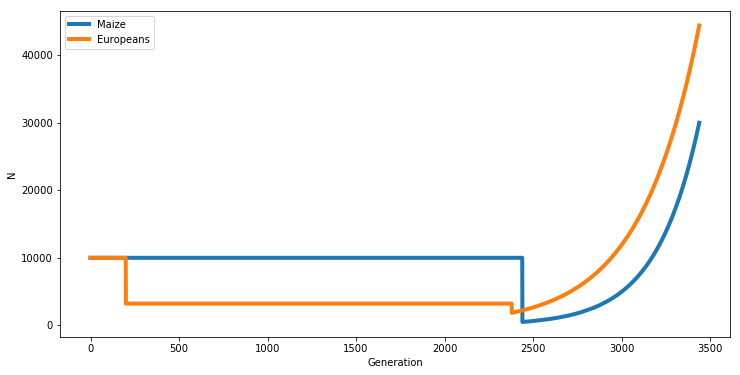

In [5]:
plt.plot(demog_maize, linewidth=4.0,label='Maize')
plt.plot(demog_euro, linewidth=4.0,label='Europeans')
plt.ylabel('N')
plt.xlabel('Generation')
plt.legend()
#savefig('../figures/demog_maize_euro.png', bbox_inches='tight',dpi=300)

## General parameters
### burnin demography
Constant population size for 10N generations to reach equilibrium

In [6]:
nlist=np.array([Nstart]*int(10*Nstart),dtype=np.uint32)

### Regions
- 1 locus with 25 segments of 4kb each.
- central region with deleterious sites (negative s) following a $\gamma$ distribution with mean of $5*10^{-3}$ and shape 0.3
- 3/4 of mutations in cental region are deleterious and 1/4 are neutral
- mutation rates are constant at $3*10^{-7}$ per bp
- recombination rate equals mutation rate


In [7]:
rng2=fp11.GSLrng(101)
pop1=fp11.SlocusPop(Nstart)


# regions
sregion = [fp11.GammaS(12, 13, 0.75, -5e-3,0.3, coupled=True)]
#sregion = []
nregion = [fp11.Region(i,i+1,1, coupled=True) for i in range(12)] + \
          [fp11.Region(12,13,0.25, coupled=True)] +\
          [fp11.Region(i,i+1,1, coupled=True) for i in range(13,25)]


p = {'nregions':nregion,
'sregions': sregion,
'recregions':[fp11.Region(0,25,1)],
'rates':(0.03,0.03,0.03),
'demography':nlist,
}

params = fp11.model_params.SlocusParams(**p)

## run burnin

In [8]:
wf.evolve(rng2, pop1,params)
print('burnin done')

burnin done


Copying the burnin population to use the same burnin for maize and human sims

In [9]:
ppop = pickle.dumps(pop1,-1)
pop2 = pickle.loads(ppop)
print(pop1==pop2)

True


## Recorder for $\pi$ and singeltons

In [10]:
def str2byte(tup,fmtstring):
    byte_tup = (tup[0],bytearray(tup[1],fmtstring))
    return(byte_tup)

class neutral_div:
    def __init__(self):
        self.values = []#[['gen']+[i for i in range(25)]]
        self.singleton = []#[['gen'] + [i for i in range(25)]]
    def __call__(self, pop):
        if pop.generation % 100 == 0:
            samp = fp11.sampling.sample_separate(rng2, pop, 500, True)
            neutral_sample = polyt.SimData([str2byte(mut, 'utf-8') for mut in samp[0]])
            w = Windows(neutral_sample, window_size=1, step_len=1, starting_pos=0., ending_pos=25.0)
            window_pi = [PolySIM(w[i]).thetapi() for i in range(len(w))]
            window_singleton = [PolySIM(w[i]).numsingletons() for i in range(len(w))]
            self.values.append([pop.generation]+window_pi)
            self.singleton.append([pop.generation]+window_singleton)

## Run Maize

In [11]:
p['demography'] = demog_maize
params = fp11.model_params.SlocusParams(**p)
rec1=neutral_div()
print('GEN maize',pop1.generation)

wf.evolve(rng2, pop1,params,rec1)

GEN maize 100000


In [12]:
pi_maize = pd.DataFrame(rec1.values[1:],columns=rec1.values[0])
#pi_maize.to_csv("results/tmp_s5E-3/sim_neutralPi_maize_s5E-3_%d.csv"%run,index=False,header=False)


singleton_maize = pd.DataFrame(rec1.singleton[1:],columns=rec1.singleton[0])
#singleton_maize.to_csv("results/tmp_s5E-3/sim_singleton_maize_s5E-3_%d.csv"%run,index=False,header=False)

## Run Europenan humans

In [13]:
p['demography'] = demog_euro
params = fp11.model_params.SlocusParams(**p)
rec1=neutral_div()
print('GEN euro',pop2.generation)
wf.evolve(rng2, pop2,params,rec1)

GEN euro 100000


In [14]:
pi_european = pd.DataFrame(rec1.values[1:],columns=rec1.values[0])
#pi_european.to_csv("results/tmp_s5E-3/sim_neutralPi_European_s5E-3_%d.csv"%run,index=False,header=False)


singleton_european = pd.DataFrame(rec1.singleton[1:],columns=rec1.singleton[0])
#singleton_european.to_csv("results/tmp_s5E-3/sim_singleton_European_s5E-3_%d.csv"%run,index=False,header=False)
